In [1]:
import pandas as pd

super_df = pd.read_pickle('/nvme2/helen/EnzymeStructuralFiltering/pipeline_output_test/geometricfiltering/plip_interactions.pkl')
super_df['cofactor_moiety'] = 'C#N'
super_df['substrate_moiety'] = 'CCC'
#print("\n".join(map(str, super_df.columns)))
super_df



,Entry,tool,best_structure,avg_ligandRMSD,method,enzyme_name,protein_ID,Sequence,reaction_smiles,reaction_ID,...,buried_sasa,percentage_buried_sasa,plip_hydrogen_nbonds,plip_hydrophobic_contacts,plip_salt_bridges,plip_pi_stacking,plip_pi_cation,plip_halogen_bonds,plip_water_bridges,plip_metal_complexes
0,P3R5,boltz,P3R5_model_0_boltz,7.983860,inter_tool_weighted_avg,INC_5186,P3,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,CC/C=C(O[Si](C)(C)C)\C1=CC=CC=C1.CC/C=C(O[Si](...,R5,...,403.175000,97.854888,0,7,0,0,0,0,0,0
1,P3R5,boltz,P3R5_model_0_boltz,5.825059,inter_tool_min_per_tool,INC_5186,P3,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,CC/C=C(O[Si](C)(C)C)\C1=CC=CC=C1.CC/C=C(O[Si](...,R5,...,403.175000,97.854888,0,7,0,0,0,0,0,0
2,P3R5,vina,P3R5_2_vina,0.562602,vina_avg_intra_tool,INC_5186,P3,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,CC/C=C(O[Si](C)(C)C)\C1=CC=CC=C1.CC/C=C(O[Si](...,R5,...,353.452475,85.440532,1,10,0,0,0,0,0,0


In [27]:
import os
import pandas as pd
from pathlib import Path
import logging
from multiprocessing.dummy import Pool as ThreadPool
import numpy as np
import math
import re
from Bio.PDB import PDBIO
from Bio.PDB import PDBParser, Select, PDBIO
from biotite.structure.io.pdb import PDBFile
from biotite.structure import AtomArrayStack
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw import rdMolDraw2D # You'll need this for MolDraw2DCairo/SVG
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions
from rdkit.Geometry import Point3D
from rdkit import RDLogger
from itertools import product
from io import StringIO
import tempfile
from collections import Counter


def get_hetatm_chain_ids(pdb_path):
    with open(pdb_path, "r") as f:
        pdb_file = PDBFile.read(f)
    structure = pdb_file.get_structure()
    structure = structure[0]

    hetatm_chains = set(structure.chain_id[structure.hetero])
    atom_chains = set(structure.chain_id[~structure.hetero])

    # Exclude chains that also have ATOM records (i.e., protein chains)
    ligand_only_chains = hetatm_chains - atom_chains

    return list(ligand_only_chains)

def _norm_l1_dist(fp_a, fp_b, keys=None):
    """
    Normalized L1 distance on element counts. Used to pick the closest element-count vector
    of all ligands to the reference ligand. 
    """
    if keys is None:
        keys = set(fp_a) | set(fp_b)
    num = 0.0
    den = 0.0
    for k in keys:
        a = fp_a.get(k, 0)
        b = fp_b.get(k, 0)
        num += abs(a - b)
        den += a + b
    return 0.0 if den == 0 else num / den

def extract_chain_as_rdkit_mol(pdb_path, chain_id, sanitize=False):
    '''
    Extract ligand chain as RDKit mol objects given their chain ID. 
    '''
    # Read full structure
    with open(pdb_path, "r") as f:
        pdb_file = PDBFile.read(f)
    structure = pdb_file.get_structure()
    if isinstance(structure, AtomArrayStack):
        structure = structure[0]  # first model only

    # Extract chain
    mask = structure.chain_id == chain_id

    if len(mask) != structure.array_length():
        raise ValueError(f"Mask shape {mask.shape} doesn't match atom array length {structure.array_length()}")

    chain = structure[mask]

    if chain.shape[0] == 0:
        raise ValueError(f"No atoms found for chain {chain_id} in {pdb_path}")

    # Convert to PDB string using Biotite
    temp_pdb = PDBFile()
    temp_pdb.set_structure(chain)
    pdb_str_io = StringIO()
    temp_pdb.write(pdb_str_io)
    pdb_str = pdb_str_io.getvalue()

    # Convert to RDKit mol from PDB string
    mol = Chem.MolFromPDBBlock(pdb_str, sanitize=sanitize)

    return mol

def atom_composition_fingerprint(mol):
    """
    Returns a Counter of atom symbols in the molecule (e.g., {'C': 10, 'N': 2}).
    """
    return Counter([atom.GetSymbol() for atom in mol.GetAtoms()])


def closest_ligands_by_element_composition(ligand_mols, reference_smiles, include_h=False, top_k = 2):
    """
    Filters a list of RDKit Mol objects based on atom element composition
    matching a reference SMILES. It returns a mol object that matches the element composition. 
    Because sometimes some atoms especially hydrogens can get lost in conversions, I pick the ligand
    with the closest atom composition to the reference; doesn't have to match perfectly. 
    """
    ref_mol = Chem.MolFromSmiles(reference_smiles)
    if ref_mol is None:
        raise ValueError("Reference SMILES could not be parsed.")

    # calculate atom composition of the reference smile string i.e. the ligand of interest
    ref_fp = atom_composition_fingerprint(ref_mol)

    out = []
    for mol in ligand_mols:
        if mol is None:
            continue
        try:
            fp = atom_composition_fingerprint(mol)
            dist = _norm_l1_dist(ref_fp, fp)
            score = 1.0 - dist
            out.append((mol, score))
        except Exception as e:
            print(f"Error processing ligand: {e}")
            continue
    # return closest matching lgiands
    out.sort(key=lambda t: t[1], reverse=True)
    return [mol for mol, _ in out[:top_k]]

def as_mol(x):
    # In case anything returns (mol, score) or a dict
    if isinstance(x, Mol): return x
    if isinstance(x, tuple) and x and isinstance(x[0], Mol): return x[0]
    if isinstance(x, dict) and isinstance(x.get("mol"), Mol): return x["mol"]
    return None


METAL_ATOMIC_NUMS = {
    3,4,11,12,13,19,20,25,26,27,28,29,30, # Li Be Na Mg Al K Ca Mn Fe Co Ni Cu Zn
    47,48,49,50, # Ag Cd In Sn
    80, # Hg
    24,40, # Cr Zr
    14,5   # Si B if you consider them "metals" for mapping purposes
}


from rdkit.Chem import rdmolops, rdFMCS
from rdkit.Chem import Draw

def assign_bond_orders_fix_aromatic_no_stereo_noH(pdb_mol, ligand_smiles):
    """
    Transfer bond orders from SMILES to a PDB ligand **without hydrogens**,
    then re-perceive aromaticity and drop stereochem. Keeps original 3D coords.
    """
    ref = Chem.MolFromSmiles(ligand_smiles)
    if ref is None:
        return pdb_mol

    # Work on **heavy-atom graphs** only
    ref0 = Chem.RemoveHs(ref)                     # sanitized by default
    pdb0 = Chem.RemoveHs(Chem.Mol(pdb_mol), sanitize=False)  # keep coords, avoid valence checks

    # Kekulize template so we transfer explicit single/double bonds
    ref0_kek = Chem.Mol(ref0)
    rdmolops.Kekulize(ref0_kek, clearAromaticFlags=True)

    try:
        # Assign bond orders on the heavy-atom PDB ligand
        new0 = AllChem.AssignBondOrdersFromTemplate(ref0_kek, pdb0)

        # Drop all stereochemistry (you said you don't want it)
        Chem.RemoveStereochemistry(new0)

        # Recompute aromaticity from assigned bonds
        Chem.SanitizeMol(
            new0,
            sanitizeOps=Chem.SanitizeFlags.SANITIZE_SYMMRINGS
                      | Chem.SanitizeFlags.SANITIZE_SETCONJUGATION
                      | Chem.SanitizeFlags.SANITIZE_SETAROMATICITY
        )

        # Restore the original 3D conformer (heavy atoms align 1:1 after RemoveHs)
        if pdb_mol.GetNumConformers():
            conf = pdb0.GetConformer() if pdb0.GetNumConformers() else pdb_mol.GetConformer()
            new0.RemoveAllConformers()
            new0.AddConformer(conf, assignId=True)

        return new0  # heavy-atom ligand with correct bond orders & arom, no stereo

    except Exception as e:
        print("AssignBondOrdersFromTemplate (noH) failed:", e)
        return pdb_mol



def find_substructure_matches(mol, sub, is_smarts=False, use_chirality=False):
    """
    sub: SMILES (default) or SMARTS (if is_smarts=True).
    Returns list of tuples of atom indices.
    """
    q = Chem.MolFromSmarts(sub) if is_smarts else Chem.MolFromSmiles(sub)
    if q is None:
        raise ValueError("Could not parse substructure pattern.")
    return list(mol.GetSubstructMatches(q, useChirality=use_chirality, uniquify = True))

def coords_of_atoms(mol, atom_indices):
    conf = mol.GetConformer()
    pts = [conf.GetAtomPosition(i) for i in atom_indices]
    return np.array([[p.x, p.y, p.z] for p in pts])



In [31]:
# Extract chain IDs of ligands
chain_ids = get_hetatm_chain_ids('/nvme2/helen/EnzymeStructuralFiltering/pipeline_output_test/superimposition/superimposed_structures/P3R4/P3R4_0_chai__P3R4_4_chai.pdb')

# Extract ligands as RDKit mol objects
ligands = []
for chain_id in chain_ids:
    mol  = extract_chain_as_rdkit_mol('/nvme2/helen/EnzymeStructuralFiltering/pipeline_output_test/superimposition/superimposed_structures/P3R4/P3R4_0_chai__P3R4_4_chai.pdb', chain_id, sanitize=False)
    ligands.append(mol)


cofactor_smiles = r'CC1=C(/C2=C/C3=N/C(C(C)=C3CCC(O)=O)=C\C4=C(C(C=C)=C(/C=C5N=C(C(C=C)=C\5C)/C=C1\N2/6)N4[Fe]6=C\C#N)C)CCC(O)=O'
cofactor_moiety = 'C#N'

cofactor_candidates = closest_ligands_by_element_composition(ligands, cofactor_smiles, top_k=1)
cofactor_mol = as_mol(cofactor_candidates[0]) if cofactor_candidates else None
cofactor_mol = as_mol(cofactor_candidates[0]) if cofactor_candidates else None

f = assign_bond_orders_fix_aromatic_no_stereo_noH(cofactor_mol, cofactor_smiles)
f

def mol_with_atom_indices(mol):
    """Return a copy of mol with atom indices as atom map numbers."""
    m = Chem.Mol(mol)  # copy
    for atom in m.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return m

def save_mol_with_indices(mol, filename="mol.png"):

    if mol is None:
        raise ValueError("Could not parse SMILES")
    mol = mol_with_atom_indices(mol)
    img = Draw.MolToImage(mol, size=(500, 500))
    img.save(filename)
    print(f"Saved molecule with indices to {filename}")

save_mol_with_indices(f)
cofactor_centroids = find_substructure_matches(f, cofactor_moiety)
cofactor_centroids

Saved molecule with indices to mol.png


[10:35:19] WARNING: More than one matching pattern found - picking one



[(38, 39)]

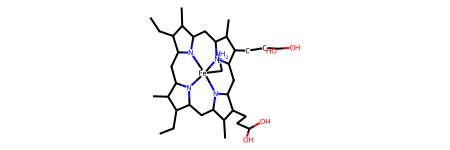

In [14]:
cofactor_mol